## Setup

In [1]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import numpy as np
import pandas as pd
import random
# import cudf as pd
import tensorflow as tf
import isuelogit as isl
import glob

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/Library/CloudStorage/OneDrive-Personal/data-science/github/gisuelogit


In [3]:
# Internal modules
from src.gisuelogit.models import UtilityParameters, BPRParameters, ODParameters, GISUELOGIT, NGD
from src.gisuelogit.visualizations import plot_predictive_performance, plot_convergence_estimates
from src.gisuelogit.networks import load_k_shortest_paths, read_paths, build_fresno_network, \
    Equilibrator, sparsify_OD, ColumnGenerator, read_OD
from src.gisuelogit.etl import get_design_tensor, get_y_tensor, data_curation, temporal_split
from src.gisuelogit.descriptive_statistics import mse, btcg_mse, mnrmse, nrmse

In [4]:
# Seed for reproducibility
_SEED = 2022
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

## Build Fresno network

In [5]:
fresno_network = build_fresno_network()

## Read OD matrix

In [6]:
read_OD(network=fresno_network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs


## Read paths

In [7]:
#read_paths(network=fresno_network, update_incidence_matrices=True, filename='paths-fresno.csv')
read_paths(network=fresno_network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

# For quick testing
# Q = fresno_network.load_OD(sparsify_OD(fresno_network.Q, prop_od_pairs=0.99))
# load_k_shortest_paths(network=fresno_network, k=2, update_incidence_matrices=True)

18289 paths were read in 33.8[s]              

18289 paths were loaded in the network

Updating incidence matrices

Matrix D (2413, 18289) generated in 33.1[s]               

Matrix M (6970, 18289) generated in 12.2[s]               

Matrix C (18289, 18289) generated in 6.4[s]               



## Read spatiotemporal data

In [32]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*fresno-link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[df['date'].dt.dayofweek.between(0, 3)]
# df = df[df['date'].dt.year == 2019]

df['period'] = df['date'].astype(str) + '-' + df['hour'].astype(str)
df['period'] = df.period.map(hash)

## Data curation

In [33]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

df = data_curation(df)

## Utility function

In [34]:
features_Z = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

utility_parameters = UtilityParameters(features_Y=['tt'],
                                       features_Z=features_Z,
                                       periods = 1,
                                       initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                       'fixed_effect': np.zeros_like(fresno_network.links)},
                                       signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                              'bus_stops': '-', 'intersections': '-'},
                                       trainables={'psc_factor': False, 'fixed_effect': False},
                                       )

utility_parameters.constant_initializer(0)

## Data processing

In [35]:
n_links = len(fresno_network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [36]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix']].describe()

,counts,tt_ff,tt_avg,tf_inrix
count,6748.000000,115824.000000,100444.000000,115824.000000
mean,1865.514775,0.003415,0.003899,0.201742
std,791.520665,0.004370,0.004680,0.233323
min,3.000000,0.000000,0.000000,0.000000
25%,1339.000000,0.000000,0.000000,0.000000
50%,1771.100000,0.002503,0.002939,0.151000
75%,2297.000000,0.004702,0.005678,0.288000
max,4784.000000,0.070349,0.059900,4.605000


In [37]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix']].describe()

,counts,tt_ff,tt_avg,tf_inrix
count,5492.000000,94107.000000,84165.000000,94107.000000
mean,1793.271103,0.003377,0.003794,0.199839
std,790.101857,0.004327,0.004502,0.230672
min,31.000000,0.000000,0.000000,0.000000
25%,1258.875000,0.000000,0.000000,0.000000
50%,1666.300000,0.002491,0.002883,0.151000
75%,2207.250000,0.004578,0.005447,0.280000
max,4766.000000,0.070349,0.058472,3.775000


In [38]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in fresno_network.links:
    fresno_network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==str(link.key)])

In [39]:
# Select only dates used for previous paper

# df = df.query('date == "2019-10-01"  | date == "2020-10-06"')
# df = df.query('date == "2019-10-01"')
df = df.query('hour == 16')
# df = df.query('hour == 17')

## EDA

In [40]:
eda_df = df.copy()
eda_df['date'] = eda_df['date'].astype(str)

# Transform to monthly income
eda_df['median_inc'] = eda_df['median_inc']/12

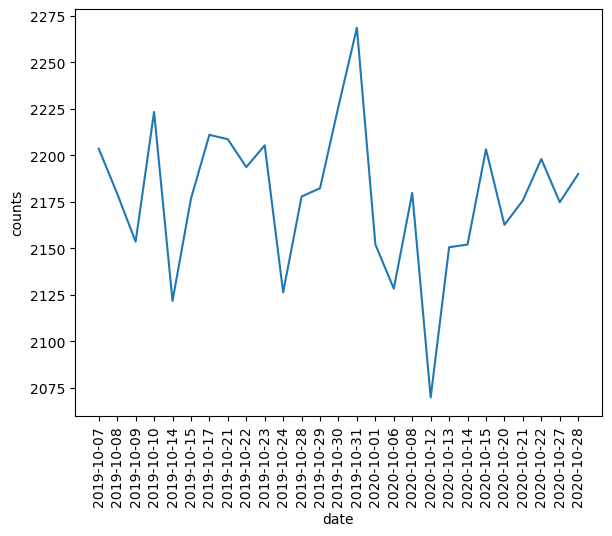

In [41]:
sns.lineplot(x= 'date', y = 'counts', data =eda_df.groupby('date')[['counts']].mean().reset_index())
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

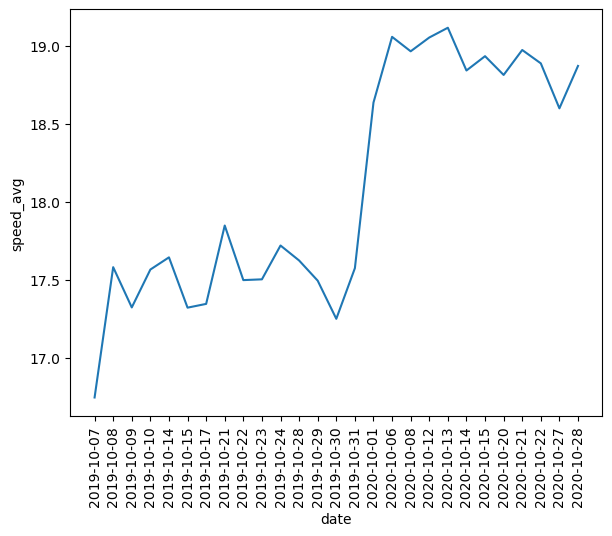

In [43]:
sns.lineplot(x= 'date', y = 'speed_avg', data =eda_df.groupby('date')[['speed_avg']].mean().reset_index())
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

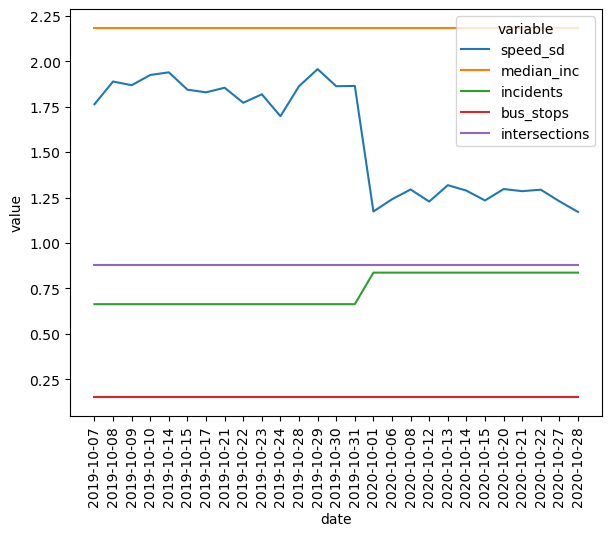

In [44]:
sns.lineplot(x= 'date', y = 'value', hue = 'variable', data =pd.melt(eda_df.groupby('date')[features_Z].mean().reset_index(),id_vars= ['date']))
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

## Training and validation sets

In [45]:
df = df.sort_values(by = 'date').copy()

for year in sorted(df['year'].unique()):
    df_year = df[df['year'] == year]

    n_days, n_hours = len(df_year.date.unique()), len(df_year.hour.unique())

    traveltime_data = get_y_tensor(y=df_year[['tt_avg']], n_links=n_links, n_days=n_days, n_hours=n_hours)
    flow_data = get_y_tensor(y=df_year[['counts']], n_links=n_links, n_days=n_days, n_hours=n_hours)

    Y[year] = tf.concat([traveltime_data, flow_data], axis=3)

    X[year] = get_design_tensor(Z=df_year[features_Z], n_links=n_links, n_days=n_days, n_hours=n_hours)

    tt_ff = get_design_tensor(Z=df_year[['tt_ff']], n_links=n_links, n_days=n_days, n_hours=n_hours)

In [46]:
# We only pick data from one year
X = X[2019]
Y = Y[2019]

# Prepare the training and validation dataset
X, Y = tf.concat(X,axis = 0), tf.concat(Y,axis = 0)
#X_train, X_test, Y_train, Y_test = train_test_split(X.numpy(), Y.numpy(), test_size=0.5, random_state=_SEED)
X_train, X_test, Y_train, Y_test = temporal_split(X.numpy(), Y.numpy(), n_days = X.shape[0])
X_train, X_test, Y_train, Y_test = [tf.constant(i) for i in [X_train, X_test, Y_train, Y_test]]

## Network equilibrium predictor

In [47]:
equilibrator = Equilibrator(
    network=fresno_network,
    # paths_generator=paths_generator,
    utility=utility_parameters,
    max_iters=100,
    method='fw',
    iters_fw=50,
    accuracy=1e-4,
)

column_generator = ColumnGenerator(equilibrator=equilibrator,
                                   utility=utility_parameters,
                                   n_paths=0,
                                   ods_coverage=0.1,
                                   ods_sampling='sequential',
                                   # ods_sampling='demand',
                                   )

## Configuration

In [19]:
#_EPOCHS = {'learning': 50, 'equilibrium': 10}
_EPOCHS = {'learning': 500, 'equilibrium': 0}
_BATCH_SIZE = None
_LR = 5e-1
_RELATIVE_GAP = 1e-5
_XTICKS_SPACING = 50
_EPOCHS_PRINT_INTERVAL = 10

_LOSS_METRIC  = nrmse

# Excluding historic OD gives more freedom for the model to find an equilibria and minimize reconstruction error
_LOSS_WEIGHTS ={'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1}
_MOMENTUM_EQUILIBRIUM = 0.99
#_MOMENTUM_EQUILIBRIUM = 1

# Including historic OD matrix
# _LOSS_WEIGHTS ={'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1}
# _MOMENTUM_EQUILIBRIUM = 0.99

# _LOSS_METRIC = mse
# _LOSS_WEIGHTS ={'od': 1, 'theta': 0, 'tt': 1e10, 'flow': 1, 'eq_flow': 1}

#_LOSS_METRIC  = btcg_mse
#_LOSS_METRIC  = mnrmse


## Models

In [20]:
run_model = dict.fromkeys(['equilibrium', 'lue', 'ode', 'odlue', 'odlulpe-1','odlulpe-2', 'tvodlulpe'], False)

run_model['lue'] = True
run_model['ode'] = True
run_model['odlue'] = True
run_model['odlulpe-1'] = True
run_model['odlulpe-2'] = True

In [21]:
train_results_dfs = {}
test_results_dfs = {}

### Model 2: Benchmark of gisuelogit and isuelogit


LUE: Benchmark of gisuelogit and isuelogit (utility only)

Epoch: 0, n_train: 9, n_test: 9

0: train_loss=2.9e+06, val_loss=3e+06, train_loss tt=3.6e-05, val_loss tt=3.5e-05, train_loss flow=2.9e+06, val_loss flow=3e+06, theta = [0. 0. 0. 0. 0. 0.], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, lambda eq=1, relative x=1.2e-16, relative gap=1e-05, train flow equilibrium loss=2.9e-26, time: 15.8

Epoch: 1, n_train: 9, n_test: 9

1: train_loss=1e+06, val_loss=1.1e+06, train_loss tt=3.5e-05, val_loss tt=3.4e-05, train_loss flow=2.9e+06, val_loss flow=2.9e+06, theta = [-0.4978 -0.5     0.     -0.5    -0.4997 -0.5   ], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0.24, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, lambda eq=0.34, relative x=0.22, relative gap=23, train flow equilibrium loss=2.6e+05, time: 21.1

Epoch: 10, n_train: 9, n_test: 9

10: train_loss=8.1e+05, val_loss=8.9e+05, train_loss tt=2.6e-05, val

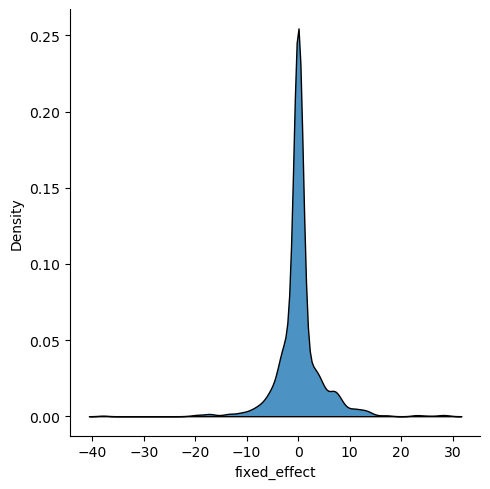

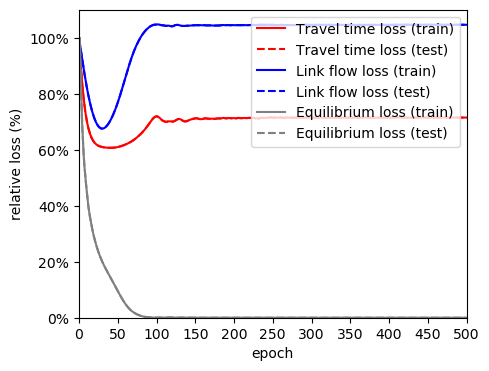

In [22]:
if run_model['lue']:
    print('\nLUE: Benchmark of gisuelogit and isuelogit (utility only)')

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'speed_sd': True, 'median_inc': True, 'incidents': True,
                                                              'bus_stops': True, 'intersections': True
                                                       },
                                           )

    utility_parameters.constant_initializer(0)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 initial_values=fresno_network.q.flatten(),
                                 true_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=False)

    equilibrator = Equilibrator(
        network=fresno_network,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       )

    lue = GISUELOGIT(
        key='lue',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator = equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters
    )

    train_results_dfs['lue'], test_results_dfs['lue'] = lue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        threshold_relative_gap=_RELATIVE_GAP,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        loss_weights= dict(_LOSS_WEIGHTS, od = 0),
        loss_metric=_LOSS_METRIC,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    sns.displot(pd.DataFrame({'fixed_effect':np.array(lue.fixed_effect)}),
            x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    plot_predictive_performance(train_losses=train_results_dfs['lue'], val_losses=test_results_dfs['lue'],
                                xticks_spacing = _XTICKS_SPACING)


    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}")
    print(f"alpha = {lue.alpha: 0.2f}, beta  = {lue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 3: OD + utility estimation with historic OD


ODLUE: OD + utility estimation with historic OD

Epoch: 0, n_train: 9, n_test: 9

0: train_loss=2.9e+06, val_loss=3e+06, train_loss tt=3.6e-05, val_loss tt=3.5e-05, train_loss flow=2.9e+06, val_loss flow=3e+06, theta = [0. 0. 0. 0. 0. 0.], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, lambda eq=1, relative x=1.2e-16, relative gap=1e-05, train flow equilibrium loss=2.9e-26, time: 13.9

Epoch: 1, n_train: 9, n_test: 9

1: train_loss=1.1e+06, val_loss=1.1e+06, train_loss tt=3.5e-05, val_loss tt=3.4e-05, train_loss flow=2.9e+06, val_loss flow=2.9e+06, theta = [-0.4978 -0.5     0.     -0.5    -0.4997 -0.5   ], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0.24, avg alpha=0.15, avg beta=4, loss demand=5.1, lambda eq=0.34, relative x=0.26, relative gap=23, train flow equilibrium loss=3.2e+05, time: 19.2

Epoch: 10, n_train: 9, n_test: 9

10: train_loss=7.9e+05, val_loss=8.6e+05, train_loss tt=2.5e-05, val_loss tt=2.6

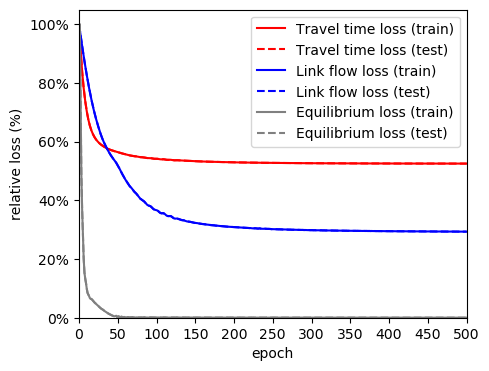

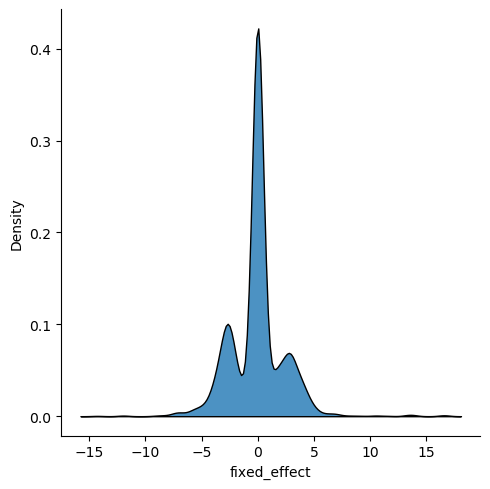

In [23]:
if run_model['odlue']:

    print('\nODLUE: OD + utility estimation with historic OD')

    # _RELATIVE_GAP = 1e-4\
    # _XTICKS_SPACING = 50

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)
    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)
    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'speed_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlue = GISUELOGIT(
        key='odlue',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlue'], test_results_dfs['odlue'] = odlue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        # generalization_error={'train': False, 'validation': True},
        loss_weights= _LOSS_WEIGHTS,
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['odlue'], val_losses=test_results_dfs['odlue'],
                                xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.DataFrame({'fixed_effect':np.array(odlue.fixed_effect)}),
            x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}")
    print(f"alpha = {odlue.alpha: 0.2f}, beta  = {odlue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 4: ODLUE + link specific performance parameters (only alphas)


ODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alpha)

Epoch: 0, n_train: 9, n_test: 9

0: train_loss=2.9e+06, val_loss=3e+06, train_loss tt=3.6e-05, val_loss tt=3.5e-05, train_loss flow=2.9e+06, val_loss flow=3e+06, theta = [0. 0. 0. 0. 0. 0.], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, lambda eq=1, relative x=1.2e-16, relative gap=1e-05, train flow equilibrium loss=2.9e-26, time: 13.5

Epoch: 1, n_train: 9, n_test: 9

1: train_loss=1.1e+06, val_loss=1.1e+06, train_loss tt=2.5e-05, val_loss tt=2.5e-05, train_loss flow=2.9e+06, val_loss flow=2.9e+06, theta = [-0.4978 -0.5     0.     -0.5    -0.4997 -0.5   ], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0.24, avg alpha=0.16, avg beta=4, loss demand=5.1, lambda eq=0.34, relative x=0.26, relative gap=23, train flow equilibrium loss=3.2e+05, time: 23.2

Epoch: 10, n_train: 9, n_test: 9

10: train_loss=7.8e+05, val_loss=8.6

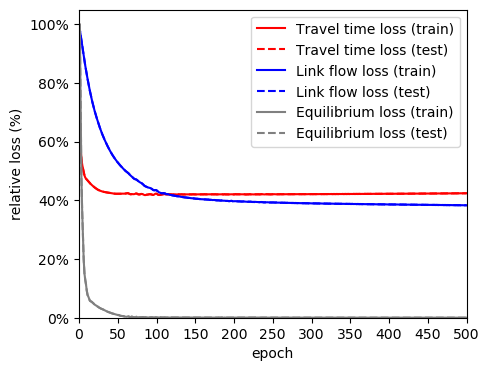

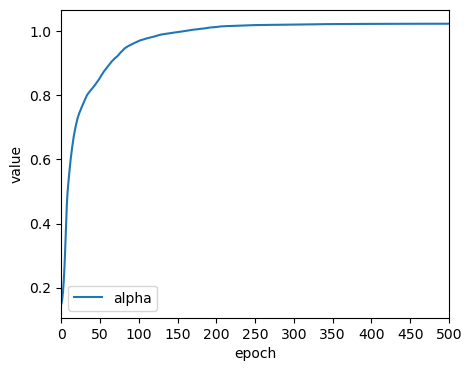

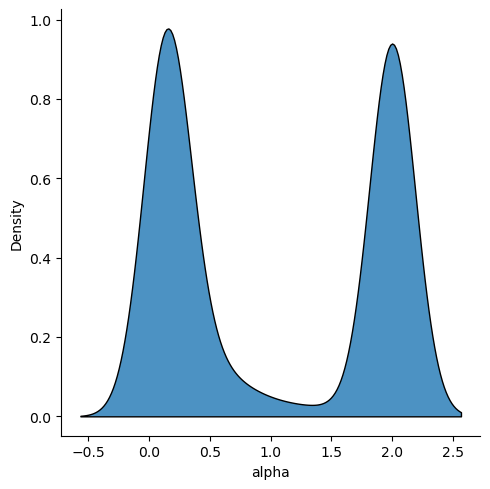

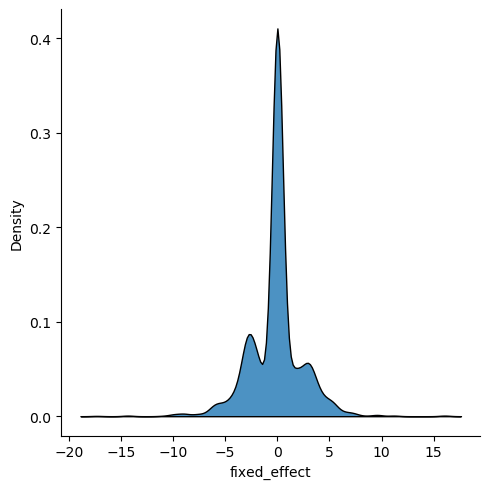

In [24]:
if run_model['odlulpe-1']:

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alpha)')

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # _LR = 1e-2
    # _RELATIVE_GAP = 1e-5
    # _XTICKS_SPACING = 50

    # Some initializations of the bpr parameters, makes the optimization to fail (e.g. alpha =1, beta = 1). Using a common
    # alpha but different betas for every link make the estimation more stable but there is overfitting after a certain amount of iterations

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   # initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                   #                 'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15,
                                   #                 'beta': 4 * np.ones_like(fresno_network.links, dtype=np.float32)},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta':False},
                                   # trainables={'alpha': True, 'beta': True},
                                   # trainables={'alpha': False, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'psc_factor': 0, 'tt':0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'speed_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlulpe_1 = GISUELOGIT(
        key='odlulpe-1',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlulpe-1'], test_results_dfs['odlulpe-1'] = odlulpe_1.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights=_LOSS_WEIGHTS,
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['odlulpe-1'], val_losses=test_results_dfs['odlulpe-1'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe-1'][['epoch','alpha']],
                                xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.DataFrame({'alpha':odlulpe_1.alpha}),
            x="alpha", multiple="stack", kind="kde", alpha = 0.8)

    sns.displot(pd.DataFrame({'fixed_effect':np.array(odlulpe_1.fixed_effect)}),
                x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_1.theta.numpy())))}")
    print(f"alpha = {np.mean(odlulpe_1.alpha): 0.2f}, beta  = {np.mean(odlulpe_1.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_1.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 5: ODLUE + link specific performance parameters (alphas and betas)


ODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)

Epoch: 0, n_train: 9, n_test: 9

0: train_loss=2.9e+06, val_loss=3e+06, train_loss tt=3.6e-05, val_loss tt=3.5e-05, train_loss flow=2.9e+06, val_loss flow=3e+06, theta = [0. 0. 0. 0. 0. 0.], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, lambda eq=1, relative x=1.2e-16, relative gap=1e-05, train flow equilibrium loss=2.9e-26, time: 14.2

Epoch: 1, n_train: 9, n_test: 9

1: train_loss=1.1e+06, val_loss=1.1e+06, train_loss tt=2.6e-05, val_loss tt=3e-05, train_loss flow=2.9e+06, val_loss flow=2.9e+06, theta = [-0.4978 -0.5     0.     -0.5    -0.4997 -0.5   ], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0.24, avg alpha=0.16, avg beta=3.9, loss demand=5.2, lambda eq=0.34, relative x=0.26, relative gap=23, train flow equilibrium loss=3.2e+05, time: 20.5

Epoch: 10, n_train: 9, n_test: 9

10: train_loss=7.8e+05, v

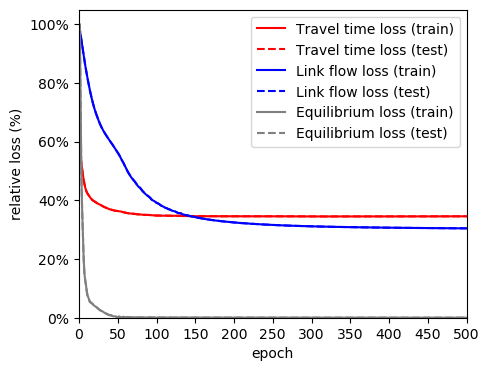

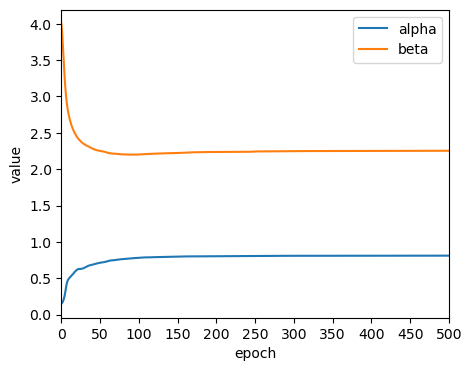

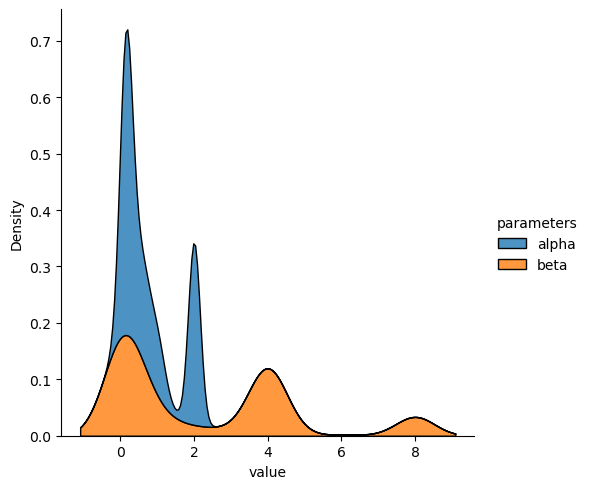

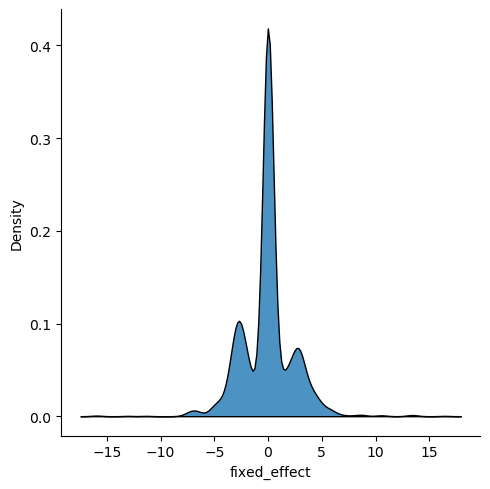

In [25]:
if run_model['odlulpe-2']:

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)')

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # _LR = 5e-1
    # _RELATIVE_GAP = 1e-5

    # Some initializations of the bpr parameters, makes the optimization to fail (e.g. alpha =1, beta = 1). Using a common
    # alpha but different betas for every link make the estimation more stable but there is overfitting after a certain amount of iterations

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   # initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                   #                 'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15,
                                   #                 'beta': 4 * np.ones_like(fresno_network.links, dtype=np.float32)},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # trainables={'alpha': True, 'beta':False},
                                   trainables={'alpha': True, 'beta': True},
                                   # trainables={'alpha': False, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'psc_factor': 0, 'tt':0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'speed_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlulpe_2 = GISUELOGIT(
        key='odlulpe_2',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlulpe_2'], test_results_dfs['odlulpe_2'] = odlulpe_2.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        # loss_weights={'od': 1, 'theta': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1},
        loss_weights=_LOSS_WEIGHTS,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        loss_metric=_LOSS_METRIC,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['odlulpe_2'], val_losses=test_results_dfs['odlulpe_2'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe_2'][['epoch','alpha','beta']],
                                xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.melt(pd.DataFrame({'alpha':odlulpe_2.alpha, 'beta': odlulpe_2.beta}), var_name = 'parameters'),
                x="value", hue="parameters", multiple="stack", kind="kde", alpha = 0.8)

    sns.displot(pd.DataFrame({'fixed_effect':np.array(odlulpe_2.fixed_effect)}),
                x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_2.theta.numpy())))}")
    print(f"alpha = {np.mean(odlulpe_2.alpha): 0.2f}, beta  = {np.mean(odlulpe_2.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_2.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

## Write csv file with estimation results

In [26]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, test_results_dfs])

train_results_df.to_csv(f"./output/tables/{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{'Fresno'}.csv")
val_results_df.to_csv(f"./output/tables/{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{'Fresno'}.csv")
